# Leak Detection Attention based LSTM model


## Introduction

This code is part of Fuel leak detection and location based on NPW.
The LSTM extends the RNN architecture with a standalone memory cell and a gating mechanism that regulates the information flow across the network. The attention layer improves the model by assigning different weights to the inputs. 
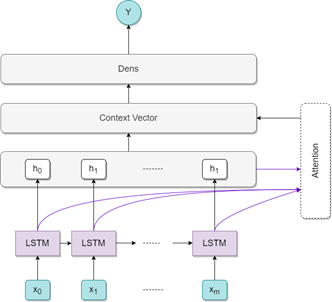

## Imports and Global Definitions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import metrics
import os
#from sklearn.metrics import * #confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.utils.vis_utils import plot_model

from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import Model

from imblearn.over_sampling import SMOTE
from IPython.display import clear_output

%matplotlib inline

Using TensorFlow backend.


In [3]:
print(tf.version.VERSION)

2.1.0


In [4]:
label_colors = ["#F58C41","#800080", "#2FAFC6",  "#AF1946", 
                "#46A5E1", "#522A64", "#A3DB05", "#FC6514"]

In [5]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Data Loading and Exploration

In [6]:
df= pd.read_csv('Train_Data_Normal.csv')
df_Test = pd.read_csv('Test_Data_Normal.csv')
pt_df=df
pt_df.head()

,File,PT,StartTime,Label,LeakTime,s0,s1,s2,s3,s4,...,s2490,s2491,s2492,s2493,s2494,s2495,s2496,s2497,s2498,s2499
0,2559,HDR3039,2019-11-06-13:32:24.20,0,7,78.986918,78.571690,78.156463,77.741235,77.326007,...,13.097855,13.172161,13.246468,13.320774,13.395081,13.469388,13.543694,13.618001,13.692308,13.766614
1,2714,GLT3023,2019-11-12-06:56:56.300,0,1168,0.000000,0.072800,0.145599,0.218399,0.291198,...,99.919385,99.928342,99.937299,99.946257,99.955214,99.964171,99.973128,99.982086,99.991043,100.000000
2,766,HDR3039,2017-03-16-16:25:39.60,0,1206,95.088042,95.098170,95.108298,95.118427,95.128555,...,0.037796,0.033596,0.029397,0.025197,0.020998,0.016798,0.012599,0.008399,0.004200,0.000000
3,302,ESH3427,2017-01-26-11:53:42.530,0,1960,0.000000,0.132741,0.265481,0.398222,0.530962,...,69.247275,69.246773,69.246271,69.245769,69.245267,69.244765,69.244263,69.243761,69.243259,69.242756
4,2024,ASK3746,2019-05-21-09:15:36.150,0,21,57.139665,56.880587,56.621508,56.362430,56.103352,...,96.886173,96.864804,96.843436,96.822067,96.800698,96.779330,96.757961,96.736592,96.715223,96.693855


In [7]:
pt_df.shape

(2240, 2505)

In [8]:
df_Test.shape

(560, 2505)

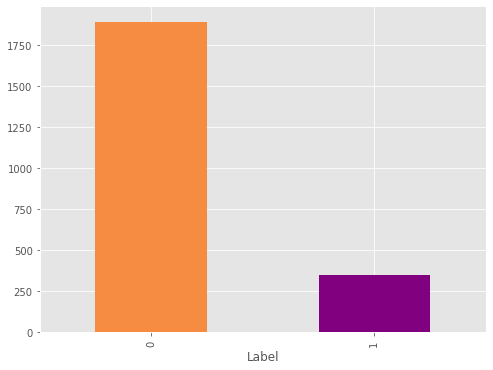

In [9]:
fig = plt.figure(figsize=(8,6))
pt_df.groupby('Label').PT.count().plot.bar(ylim=0,color=label_colors)
plt.show()

In [10]:
neg, pos = np.bincount(pt_df['Label'])
total = neg + pos
print('Total: {}\nPositive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Total: 2240
Positive: 349 (15.58% of total)



## Creating features dataframe

In [11]:
features = pt_df.drop(['File','PT','StartTime','Label','LeakTime'], axis = 1)
features.replace(np.inf, 0)
features.replace(np.nan, 0, inplace=True)
features = features.astype('int32')
features = features.astype('float32')
features.head()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s2490,s2491,s2492,s2493,s2494,s2495,s2496,s2497,s2498,s2499
0,78.0,78.0,78.0,77.0,77.0,76.0,76.0,76.0,75.0,75.0,...,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,100.0
2,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0
4,57.0,56.0,56.0,56.0,56.0,55.0,55.0,55.0,55.0,54.0,...,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0


In [12]:
features_test = df_Test.drop(['File','PT','StartTime','Label','LeakTime'], axis = 1)
features_test.replace(np.inf, 0)
features_test.replace(np.nan, 0, inplace=True)
features_test = features_test.astype('int32')
features_test = features_test.astype('float32')
features_test.head()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s2490,s2491,s2492,s2493,s2494,s2495,s2496,s2497,s2498,s2499
0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0
2,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,...,3.0,3.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0
3,49.0,49.0,50.0,50.0,50.0,51.0,51.0,52.0,52.0,52.0,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
4,92.0,92.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


In [13]:
features_test.shape

(560, 2500)

In [14]:
#Drop every second point
dropPoints =['s'+str(x*2) for x in range(0, 1250)]

In [15]:
features = features.drop(dropPoints, axis = 1)
features.head()

,s1,s3,s5,s7,s9,s11,s13,s15,s17,s19,...,s2481,s2483,s2485,s2487,s2489,s2491,s2493,s2495,s2497,s2499
0,78.0,77.0,76.0,76.0,75.0,74.0,73.0,72.0,71.0,71.0,...,12.0,12.0,12.0,12.0,13.0,13.0,13.0,13.0,13.0,13.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,100.0
2,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,...,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0
4,56.0,56.0,55.0,55.0,54.0,54.0,53.0,53.0,52.0,52.0,...,97.0,97.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0


In [16]:
features.shape

(2240, 1250)

In [17]:
features_test = features_test.drop(dropPoints, axis = 1)
features_test .head()

,s1,s3,s5,s7,s9,s11,s13,s15,s17,s19,...,s2481,s2483,s2485,s2487,s2489,s2491,s2493,s2495,s2497,s2499
0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,56.0,56.0,56.0,56.0,56.0,55.0,55.0,55.0,55.0,55.0
2,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,...,6.0,6.0,5.0,4.0,3.0,3.0,2.0,1.0,0.0,0.0
3,49.0,50.0,51.0,52.0,52.0,53.0,54.0,55.0,55.0,56.0,...,23.0,23.0,23.0,23.0,22.0,22.0,22.0,22.0,22.0,22.0
4,92.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


In [18]:
X_test = features_test
y_test = df_Test['Label']

## Split the Train Dataset to train and validation

In [19]:
#X_train, X_test, y_train, y_test = train_test_split(features,df['Label'], test_size=0.2,random_state=1)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.2,random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(features,df['Label'], test_size=0.2,random_state=1)
print("Size of:")
print("* Training-set:\t\t{}".format(len(X_train)))
print("* Validation-set:\t{}".format(len(X_valid)))
print("* Test-set:\t\t{}".format(len(X_test)))

Size of:
* Training-set:		1792
* Validation-set:	448
* Test-set:		560


In [20]:
features.shape

(2240, 1250)

In [21]:
y_train.value_counts()

0    1514
1     278
Name: Label, dtype: int64

In [22]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

In [23]:
X_train = pd.DataFrame(data = X_train[0:,0:],index=[i for i in range(X_train.shape[0])],
                      columns = ['s'+str(i) for i in range(X_train.shape[1])])

In [24]:
X_train.head()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s1240,s1241,s1242,s1243,s1244,s1245,s1246,s1247,s1248,s1249
0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98.0,98.0,98.0,98.0,98.0,98.0,99.0,99.0,99.0,99.0,...,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0
2,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,54.0,54.0,54.0,54.0,55.0,55.0,55.0,55.0,55.0,55.0
4,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,...,41.0,45.0,48.0,52.0,56.0,59.0,63.0,67.0,70.0,74.0


## Sequential Model

In [25]:
featur_size = features.shape[1]
featur_size

1250

In [26]:
X_train = X_train.values.reshape(len(X_train),featur_size,1)
X_valid = X_valid.values.reshape(len(X_valid),featur_size,1)
X_train.shape

(3028, 1250, 1)

In [27]:
X_test = X_test.values.reshape(len(X_test),featur_size,1)

## Create Attention Layer

In [28]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [29]:
featur_size =features.shape[1]
print(featur_size)

1250


In [30]:
LSTM_cell_size = 50

In [31]:
sequence_input = Input(shape=(featur_size,1))#,batch_size=4
lstm, state_h, state_c = LSTM(LSTM_cell_size, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
                             return_sequences=True, return_state=True,  name='LSTM_Layer')(sequence_input)

attention = Attention(LSTM_cell_size)
attention_result, attention_weights = attention(sequence_input, state_h)
output = Dense(1, activation='sigmoid')(attention_result)

model = Model(inputs=sequence_input, outputs=output)

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1250, 1)]         0         
_________________________________________________________________
LSTM_Layer (LSTM)            [(None, 1250, 50), (None, 10400     
_________________________________________________________________
attention (Attention)        ((None, 1), (None, 1250,  2701      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 13,103
Trainable params: 13,103
Non-trainable params: 0
_________________________________________________________________


## Training

In [33]:
#Model saving
checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [34]:
history = model.fit(x = np.array(X_train), y = np.array(y_train), epochs=150, validation_data=(np.array(X_valid), np.array(y_valid)), batch_size=30)#
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Train on 3028 samples, validate on 448 samples
Epoch 1/150
3028/3028 [==============================] - 146s 48ms/sample - loss: 3.6141 - accuracy: 0.5076 - val_loss: 1.2825 - val_accuracy: 0.1741
Epoch 2/150
3028/3028 [==============================] - 145s 48ms/sample - loss: 0.8212 - accuracy: 0.4624 - val_loss: 0.9978 - val_accuracy: 0.1696
Epoch 3/150
3028/3028 [==============================] - 144s 48ms/sample - loss: 0.7355 - accuracy: 0.4369 - val_loss: 0.8903 - val_accuracy: 0.1875
Epoch 4/150
3028/3028 [==============================] - 145s 48ms/sample - loss: 0.7015 - accuracy: 0.4369 - val_loss: 0.8340 - val_accuracy: 0.2478
Epoch 5/150
3028/3028 [==============================] - 146s 48ms/sample - loss: 0.6832 - accuracy: 0.4647 - val_loss: 0.7935 - val_accuracy: 0.3460
Epoch 6/150
3028/3028 [==============================] - 142s 47ms/sample - loss: 0.6706 - accuracy: 0.5334 - val_loss: 0.7630 - val_accuracy: 0.4576
Epoch 7/150
3028/3028 [==============================

3028/3028 [==============================] - 147s 48ms/sample - loss: 0.1845 - accuracy: 0.9386 - val_loss: 0.2057 - val_accuracy: 0.9487
Epoch 56/150
3028/3028 [==============================] - 148s 49ms/sample - loss: 0.1783 - accuracy: 0.9425 - val_loss: 0.2103 - val_accuracy: 0.9464
Epoch 57/150
3028/3028 [==============================] - 148s 49ms/sample - loss: 0.1713 - accuracy: 0.9468 - val_loss: 0.1926 - val_accuracy: 0.9554
Epoch 58/150
3028/3028 [==============================] - 149s 49ms/sample - loss: 0.1726 - accuracy: 0.9448 - val_loss: 0.1938 - val_accuracy: 0.9554
Epoch 59/150
3028/3028 [==============================] - 146s 48ms/sample - loss: 0.2556 - accuracy: 0.9092 - val_loss: 0.2494 - val_accuracy: 0.9375
Epoch 60/150
3028/3028 [==============================] - 146s 48ms/sample - loss: 0.2156 - accuracy: 0.9287 - val_loss: 0.2333 - val_accuracy: 0.9308
Epoch 61/150
3028/3028 [==============================] - 146s 48ms/sample - loss: 0.1788 - accuracy: 0.945

3028/3028 [==============================] - 144s 48ms/sample - loss: 0.1651 - accuracy: 0.9439 - val_loss: 0.2064 - val_accuracy: 0.9442
Epoch 110/150
3028/3028 [==============================] - 145s 48ms/sample - loss: 0.1618 - accuracy: 0.9462 - val_loss: 0.2225 - val_accuracy: 0.9286
Epoch 111/150
3028/3028 [==============================] - 150s 50ms/sample - loss: 0.1512 - accuracy: 0.9501 - val_loss: 0.1974 - val_accuracy: 0.9397
Epoch 112/150
3028/3028 [==============================] - 150s 49ms/sample - loss: 0.1565 - accuracy: 0.9458 - val_loss: 0.1844 - val_accuracy: 0.9375
Epoch 113/150
3028/3028 [==============================] - 147s 49ms/sample - loss: 0.1426 - accuracy: 0.9554 - val_loss: 0.1977 - val_accuracy: 0.9330
Epoch 114/150
3028/3028 [==============================] - 145s 48ms/sample - loss: 0.1367 - accuracy: 0.9564 - val_loss: 0.2036 - val_accuracy: 0.9286
Epoch 115/150
3028/3028 [==============================] - 145s 48ms/sample - loss: 0.1421 - accuracy:

### Evaluation

In [35]:
loss, accuracy = model.evaluate(np.array(X_valid),np.array(y_valid), verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Validation Accuracy:  0.9509


### Prediction

In [36]:
y_pred = model.predict(x=X_test)

In [37]:
loss, accuracy = model.evaluate(np.array(X_test),np.array(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.9250


In [38]:
y_pred2 = (model.predict(x=X_test) > 0.5).astype(np.int)

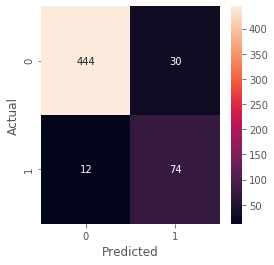

In [39]:
conf_mat=confusion_matrix(y_test, y_pred2)
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [40]:

print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.925
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       474
           1       0.71      0.86      0.78        86

    accuracy                           0.93       560
   macro avg       0.84      0.90      0.87       560
weighted avg       0.93      0.93      0.93       560



In [42]:
#model.save('AttentionRnnModel')
model.save_weights('AttentionRnnModel') #('AttentionRnnModel.h5')

In [43]:
y_pred3 = (l_model.predict(x=X_test) > 0.5).astype(np.int)
y_pred3

NameError: name 'l_model' is not defined

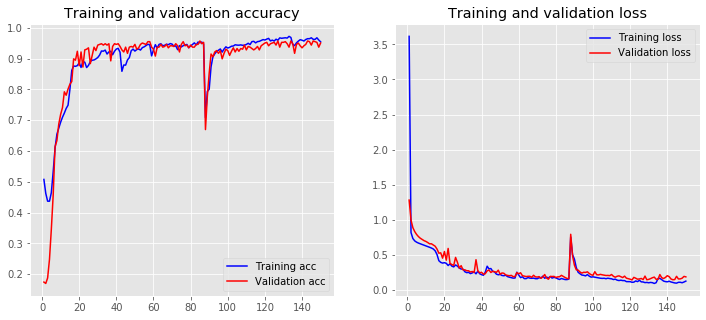

In [44]:
plot_history(history)

In [46]:
#Print incorrect predictions
y = pd.DataFrame(y_test)
y['Predict Val'] = y_pred2.flatten()
y['Prediction P'] = y_pred.flatten()
y['DIFF'] = y['Label'] - y['Predict Val']
y = y.loc[y['DIFF']  != 0]
y

,Label,Predict Val,Prediction P,DIFF
34,0,1,0.985725,-1
49,0,1,0.992405,-1
53,0,1,0.560193,-1
56,0,1,0.907231,-1
59,0,1,0.920993,-1
70,0,1,0.999960,-1
85,0,1,0.810351,-1
113,1,0,0.027221,1
121,0,1,0.910305,-1
135,0,1,0.977328,-1


In [47]:
incorrect = pt_df.iloc[y.index.tolist()]
incorrect

,File,PT,StartTime,Label,LeakTime,s0,s1,s2,s3,s4,...,s2490,s2491,s2492,s2493,s2494,s2495,s2496,s2497,s2498,s2499
34,548,ASH3038,2017-02-23-11:54:23.820,0,1871,95.254911,95.320431,95.385952,95.451473,95.516994,...,0.825563,0.733834,0.642104,0.550375,0.458646,0.366917,0.275188,0.183458,0.091729,0.000000
49,1593,GLT3031,2017-05-20-06:38:54.350,0,109,99.800136,99.800995,99.801853,99.802712,99.803570,...,0.068170,0.060595,0.053021,0.045447,0.037872,0.030298,0.022723,0.015149,0.007574,0.000000
53,667,ELR3041,2017-03-11-21:04:44.120,0,2062,2.487482,2.443667,2.399853,2.356038,2.312224,...,56.310751,56.408689,56.506627,56.604566,56.702504,56.800442,56.898380,56.996318,57.094256,57.192194
56,1758,ASH3036,2017-12-09-01:24:41.150,0,498,38.092050,37.847280,37.602510,37.357741,37.112971,...,15.512552,14.845188,14.177824,13.510460,12.843096,12.175732,11.508368,10.841004,10.173640,9.506276
59,2188,BLU3252,2019-08-04-08:34:04.590,0,569,100.000000,100.000000,100.000000,100.000000,100.000000,...,2.518657,2.238806,1.958955,1.679104,1.399254,1.119403,0.839552,0.559701,0.279851,0.000000
70,1882,ASH3036,2019-02-22-05:48:59.930,0,449,93.574791,93.527715,93.480638,93.433561,93.386484,...,33.506074,33.444191,33.382308,33.320425,33.258542,33.196659,33.134776,33.072893,33.011010,32.949127
85,2084,ASH3041,2019-06-19-10:03:28.220,0,398,89.904762,88.177871,86.450980,84.724090,82.997199,...,54.040616,53.478992,52.917367,52.355742,51.794118,51.232493,50.670868,50.109244,49.547619,48.985994
113,2614,BLU3228,2019-11-08-08:02:31.860,0,1965,73.317919,73.080925,72.843931,72.606936,72.369942,...,56.445087,55.699422,54.953757,54.208092,53.462428,52.716763,51.971098,51.225434,50.479769,49.734104
121,104,HDR3037,2017-01-09-08:59:17.940,1,1270,97.857451,97.901728,97.946004,97.990281,98.034557,...,81.873650,81.874730,81.875810,81.876890,81.877970,81.879050,81.880130,81.881209,81.882289,81.883369
135,629,ASK3746,2017-03-03-17:12:24.440,0,401,74.104414,74.297461,74.490508,74.683555,74.876602,...,7.036664,7.080209,7.123754,7.167299,7.210845,7.254390,7.297935,7.341481,7.385026,7.428571


In [48]:
incorrect.to_csv('incorrect1.csv', encoding='utf-8', index=False)

ASH3038   548
0


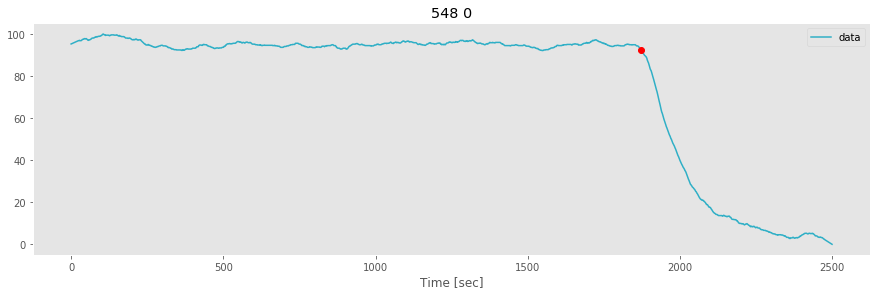

E for exite


In [49]:
    t = np.linspace(0, 2500, 2500, endpoint=False)
    for index, row in incorrect.iterrows():
        print(row['PT'], " ", row['File'])
        print(row['Label'])
        press = row.drop(['File','PT','StartTime','Label','LeakTime'])#,'maxVal','minVal','h','minPoint','maxPoint'
        data = press


        plt.subplot(2, 1, 2)
        plt.plot(t, press, '#2FAFC6', label='data')

        plt.plot(row['LeakTime'],press['s'+str(row['LeakTime'])], 'ro')
        #plt.plot(data2['LeakTime'],y['s'+str(data2['LeakTime'])], 'ro')
        

        title = str(row['File'])+" "+str(row['Label'])
        plt.title(title)
        plt.xlabel('Time [sec]')
        plt.grid()
        plt.legend()
        plt.subplots_adjust(hspace=0.35)
        
        fig_size = plt.gcf().get_size_inches() #Get current size
        sizefactor = 2.5 #Set a zoom factor
        # Modify the current size by the factor
        plt.gcf().set_size_inches(sizefactor * fig_size) 
        plt.show()
        plt.show()
        
        
        exitKey = input("E for exit")
        type(exitKey)          
        if (exitKey == 'E') or (exitKey == 'e'):    
            break
        clear_output(wait=True)